
Successfully loaded 'train.csv'. Shape: (15533, 18)
Dropped 'id' column.

--- Data Head ---
   Gender        Age    Height      Weight family_history_with_overweight  \
0    Male  24.443011  1.699998   81.669950                            yes   
1  Female  18.000000  1.560000   57.000000                            yes   
2  Female  18.000000  1.711460   50.165754                            yes   
3  Female  20.952737  1.710730  131.274851                            yes   
4    Male  31.641081  1.914186   93.798055                            yes   

  FAVC      FCVC       NCP        CAEC SMOKE      CH2O SCC       FAF  \
0  yes  2.000000  2.983297   Sometimes    no  2.763573  no  0.000000   
1  yes  2.000000  3.000000  Frequently    no  2.000000  no  1.000000   
2  yes  1.880534  1.411685   Sometimes    no  1.910378  no  0.866045   
3  yes  3.000000  3.000000   Sometimes    no  1.674061  no  1.467863   
4  yes  2.679664  1.971472   Sometimes    no  1.979848  no  1.967973   

        TUE

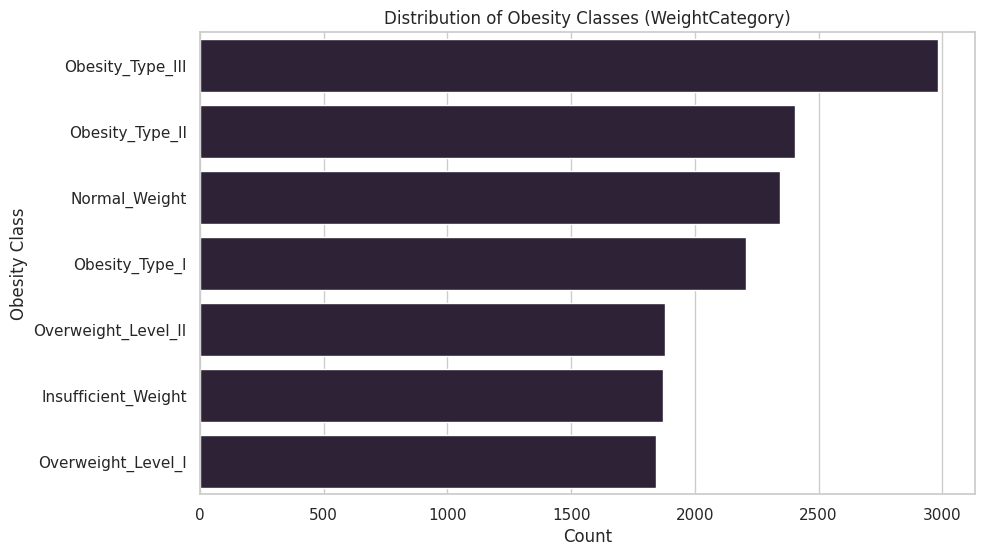

EDA: Plotted Target Variable Distribution.

1.2. Continuous vs. Target...


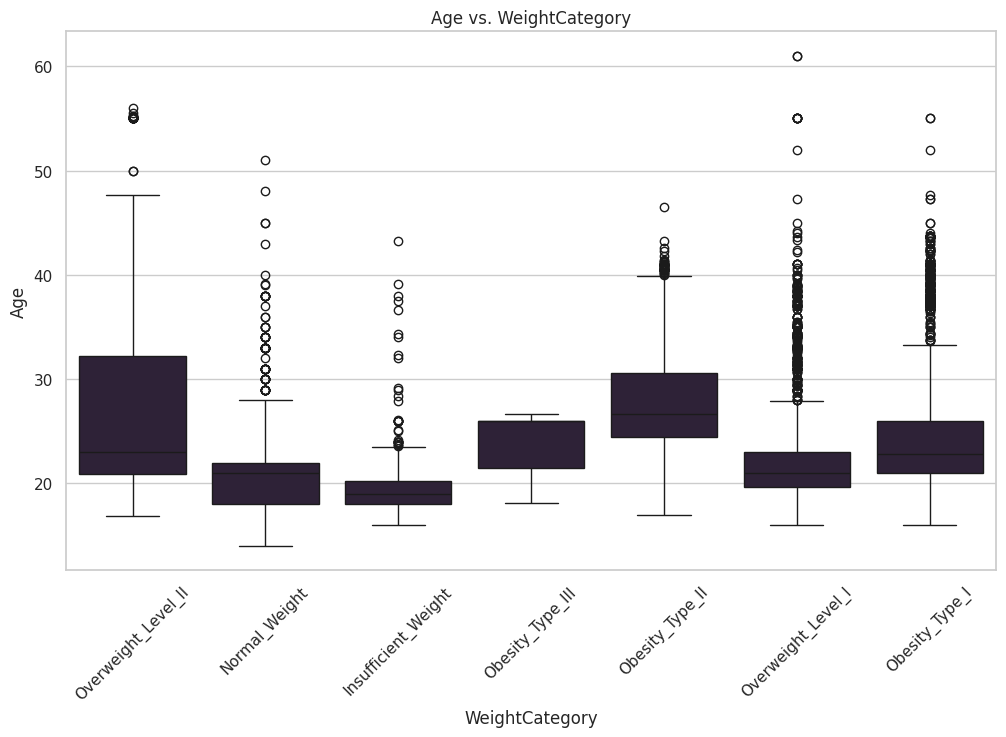

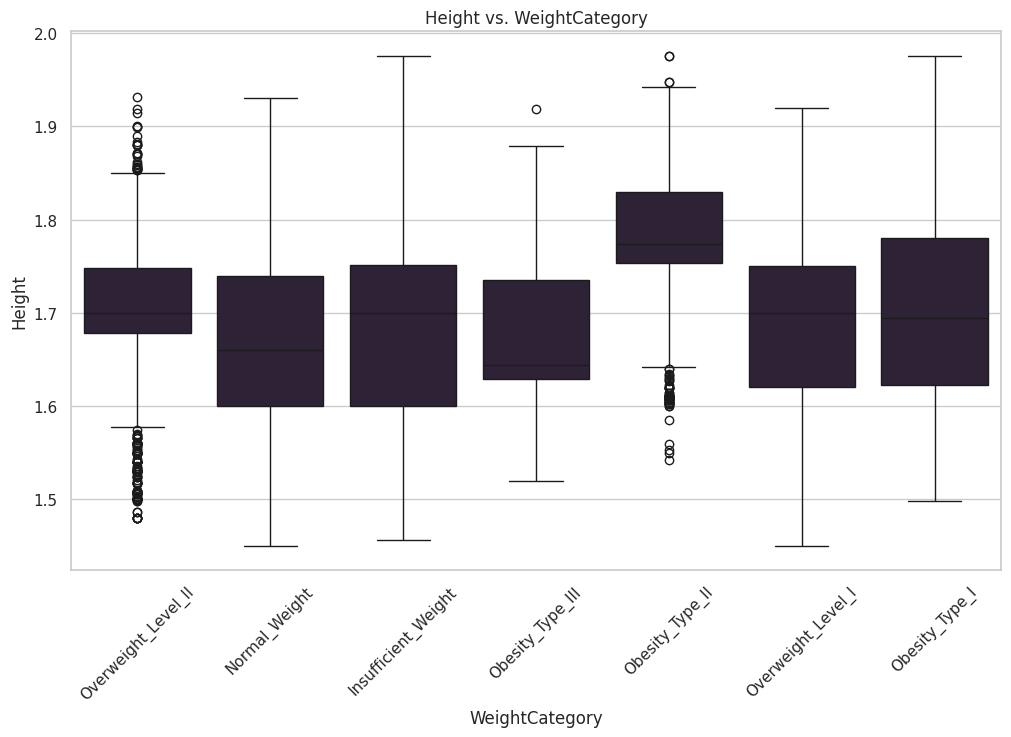

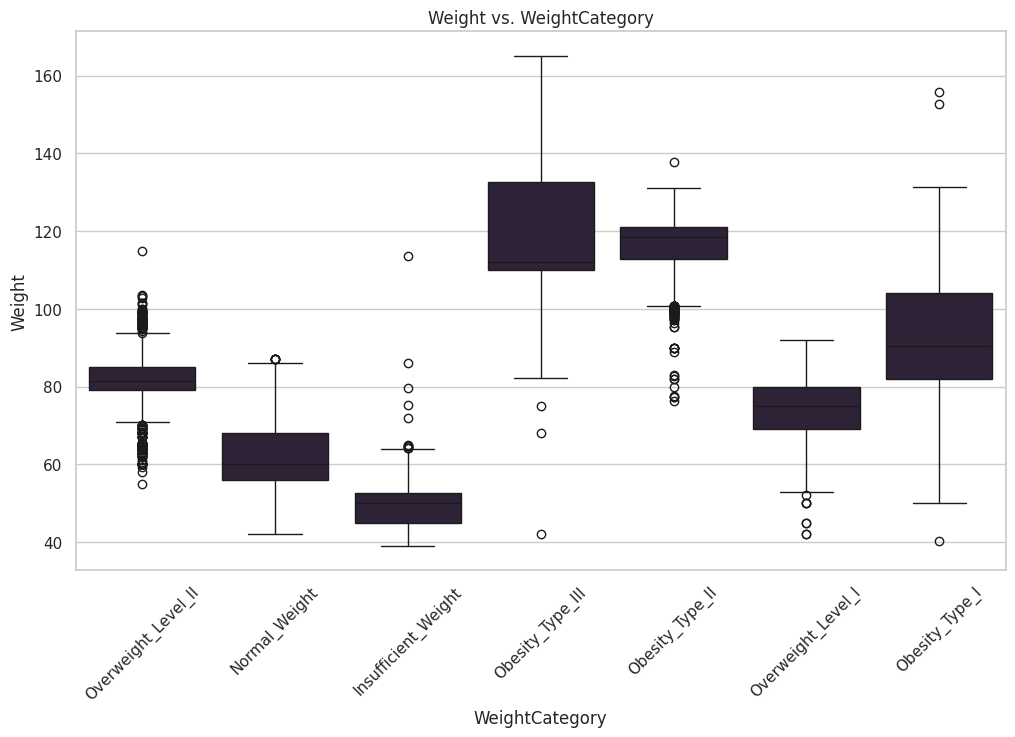

EDA: Plotted Continuous Features vs. Target.

1.3. Categorical vs. Target...


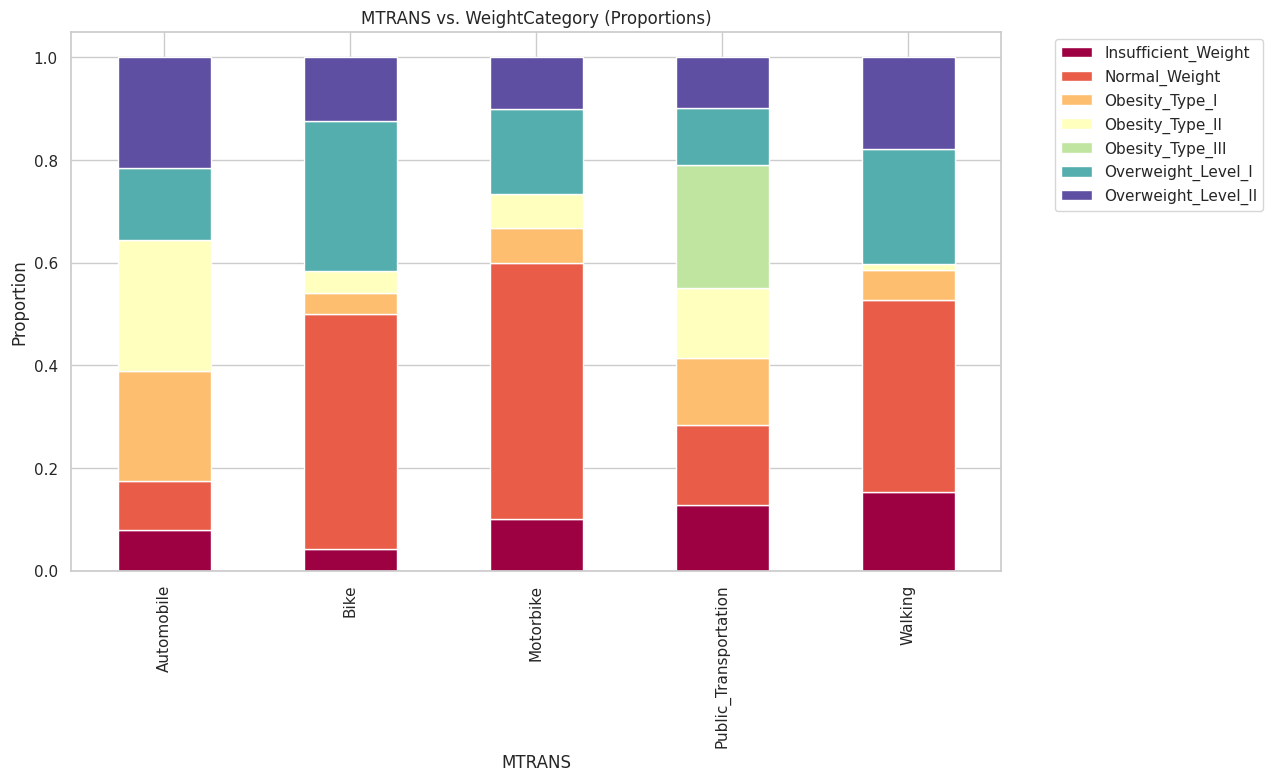

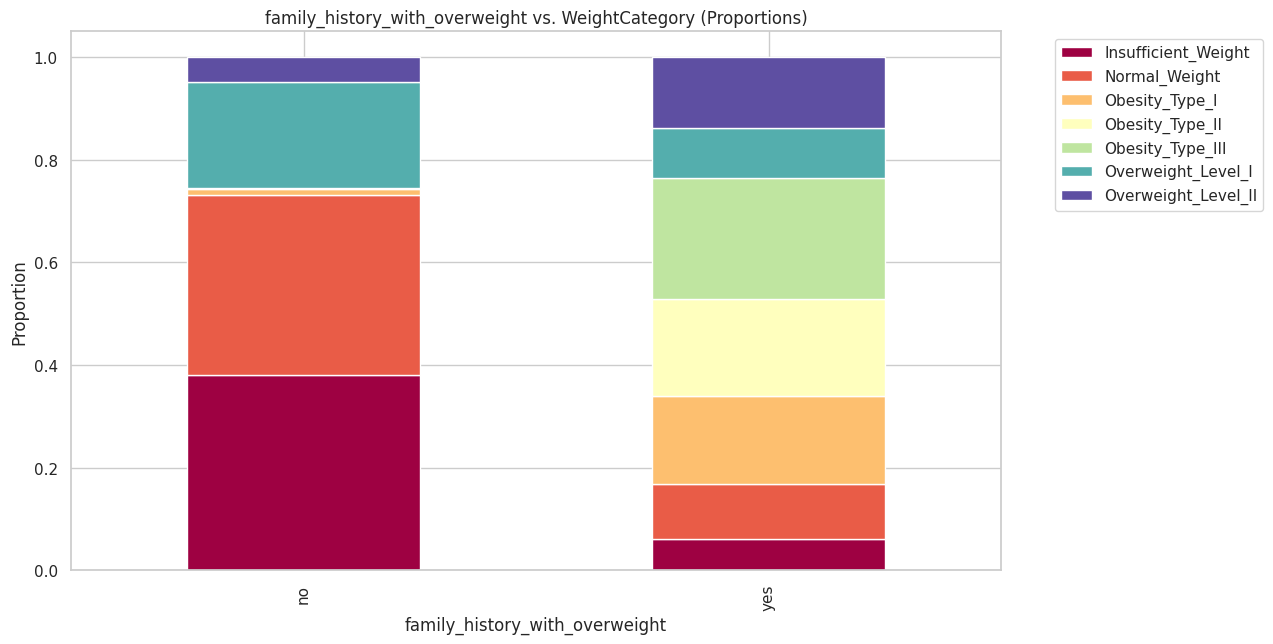

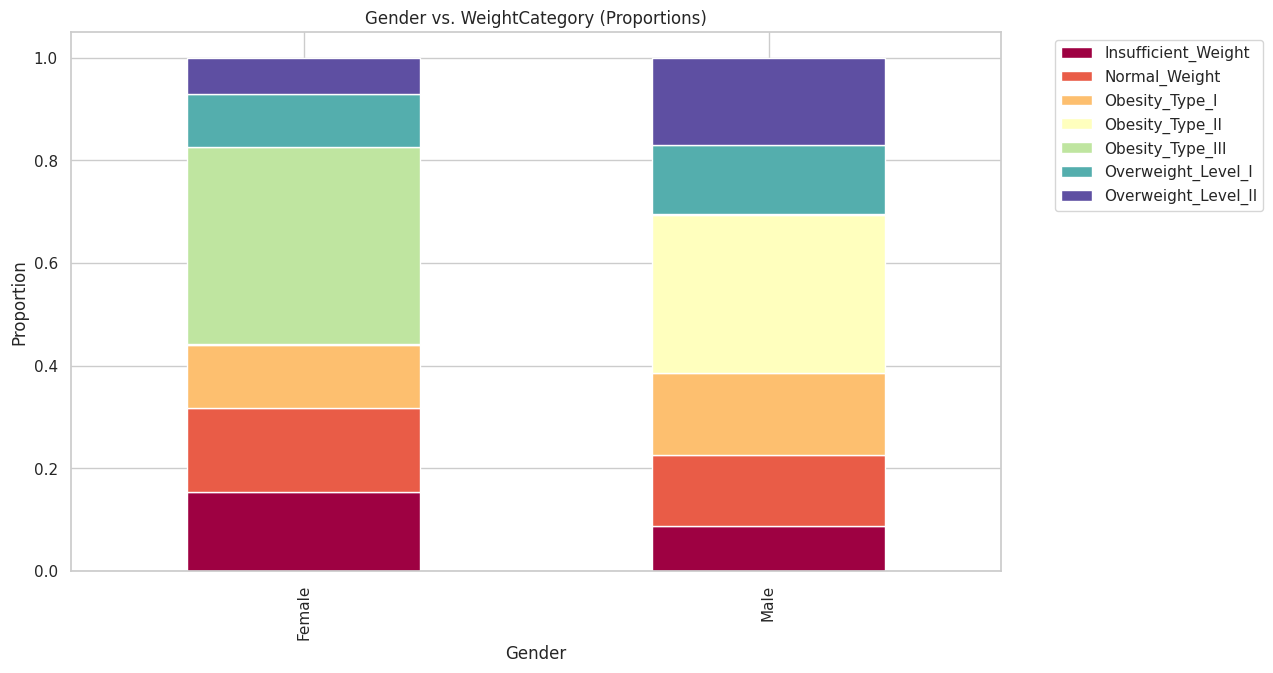

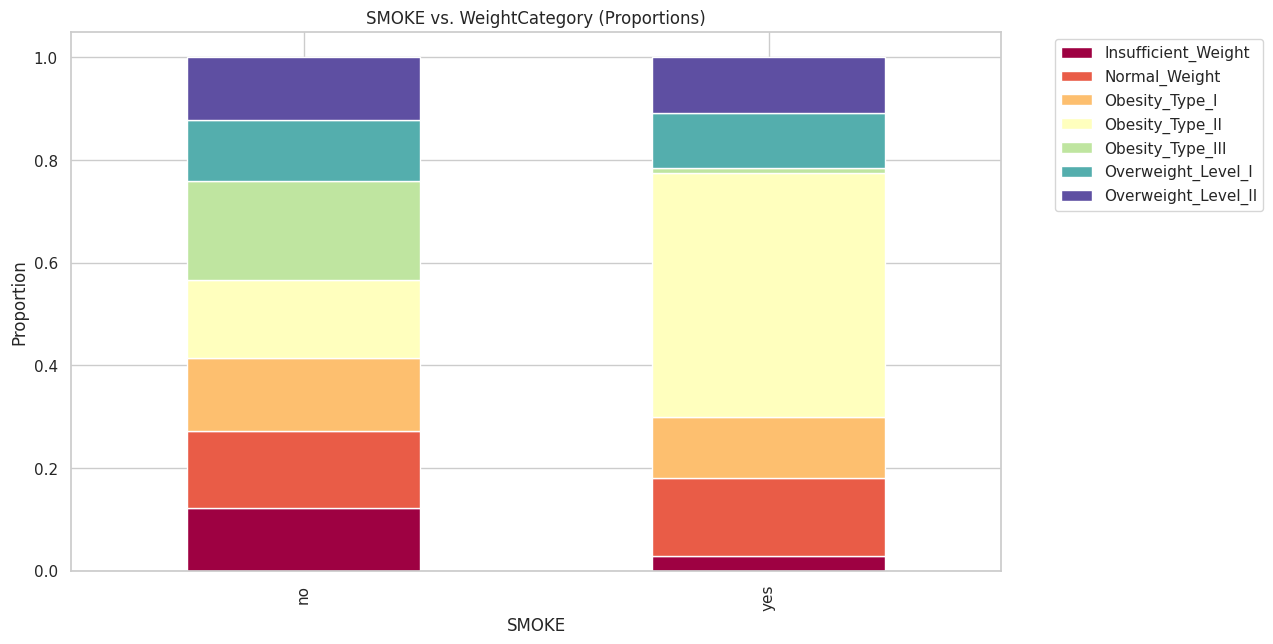

EDA: Plotted Categorical Features vs. Target.

--- Feature Engineering ---
Created 'BMI' feature.


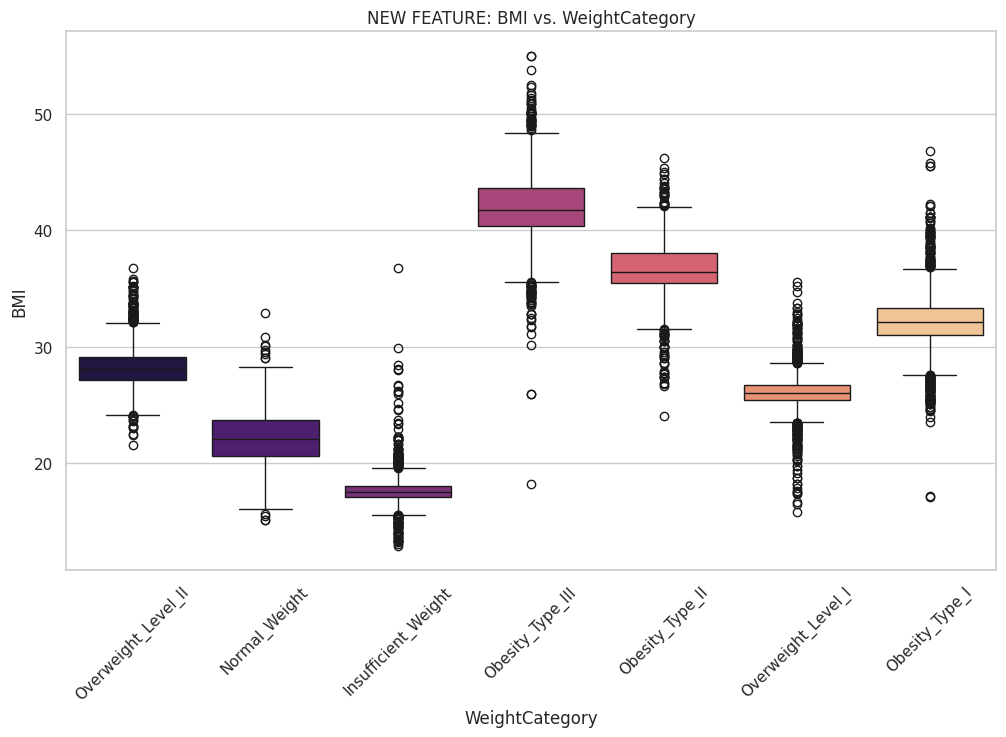

FE: Plotted new 'BMI' feature.
Created 'Activity_vs_Tech' feature.
Created 'Diet_Score' feature.
Created 'Age_Group' and 'BMI_Category' features.

Creating new interaction and behavioral features...
Total number of features (columns in X) will be: 33

Preprocessing for XGBoost
Target classes mapped: [(0, 'Insufficient_Weight'), (1, 'Normal_Weight'), (2, 'Obesity_Type_I'), (3, 'Obesity_Type_II'), (4, 'Obesity_Type_III'), (5, 'Overweight_Level_I'), (6, 'Overweight_Level_II')]

Categorical features to encode: ['Gender', 'family_history_with_overweight', 'SMOKE', 'SCC', 'MTRANS', 'Age_Group', 'BMI_Category', 'FAF_Category', 'TUE_Category']

Processed feature DataFrame (X) head:
  Gender        Age    Height      Weight family_history_with_overweight  \
0      1  24.443011  1.699998   81.669950                              1   
1      0  18.000000  1.560000   57.000000                              1   
2      0  18.000000  1.711460   50.165754                              1   
3      0  20.

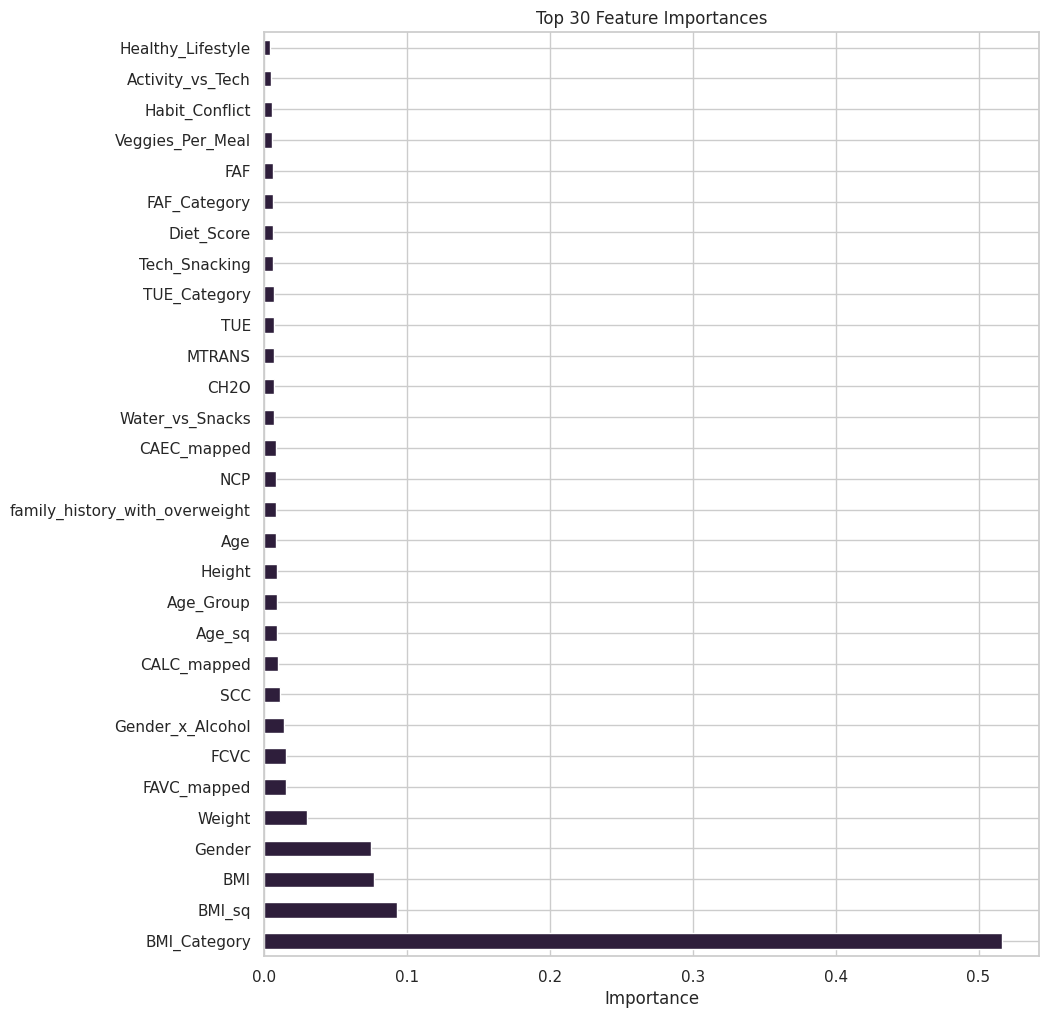

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
import xgboost
import warnings
import sys

warnings.filterwarnings('ignore')
sns.set(style='whitegrid', palette='mako')
plt.rcParams['figure.figsize'] = (12, 7)


DATA_FILE = 'train.csv'

try:
    df = pd.read_csv(DATA_FILE)
    print(f"\nSuccessfully loaded '{DATA_FILE}'. Shape: {df.shape}")

    if 'id' in df.columns:
        df = df.drop(columns=['id'])
        print("Dropped 'id' column.")

    print("\n--- Data Head ---")
    print(df.head())

except FileNotFoundError:
    print(f"\n---! ERROR !---")
    print(f"File '{DATA_FILE}' not found.")
    print("Please upload your dataset to Colab's session storage.")
    print("Stopping script.")
    raise
except Exception as e:
    print(f"An error occurred during data loading: {e}")
    raise


# EDA

print("\n--- Exploratory Data Analysis ---")

# Target Variable Distribution
print("\n1.1. Target Variable Distribution:")
print(df['WeightCategory'].value_counts(normalize=True))

plt.figure(figsize=(10, 6))
sns.countplot(y='WeightCategory', data=df, order=df['WeightCategory'].value_counts().index)
plt.title('Distribution of Obesity Classes (WeightCategory)')
plt.xlabel('Count')
plt.ylabel('Obesity Class')
plt.show()
print("EDA: Plotted Target Variable Distribution.")

# Continuous vs. Target
print("\n1.2. Continuous vs. Target...")
continuous_features = ['Age', 'Height', 'Weight']
for col in continuous_features:
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='WeightCategory', y=col, data=df)
    plt.title(f'{col} vs. WeightCategory')
    plt.xticks(rotation=45)
    plt.show()
print("EDA: Plotted Continuous Features vs. Target.")

# Categorical vs. Target
print("\n1.3. Categorical vs. Target...")
cat_features_to_plot = ['MTRANS', 'family_history_with_overweight', 'Gender', 'SMOKE']
for col in cat_features_to_plot:
    if col in df.columns:
        crosstab = pd.crosstab(df[col], df['WeightCategory'], normalize='index')
        crosstab.plot(kind='bar',
                      stacked=True,
                      figsize=(12, 7),
                      colormap='Spectral')
        plt.title(f'{col} vs. WeightCategory (Proportions)')
        plt.ylabel('Proportion')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()
print("EDA: Plotted Categorical Features vs. Target.")



# FEATURE ENGINEERING

print("\n--- Feature Engineering ---")

# BMI (Body Mass Index)
df['BMI'] = df['Weight'] / (df['Height']**2)
print("Created 'BMI' feature.")

# Plot the new BMI feature
plt.figure(figsize=(12, 7))
sns.boxplot(x='WeightCategory', y='BMI', data=df, palette='magma')
plt.title('NEW FEATURE: BMI vs. WeightCategory')
plt.xticks(rotation=45)
plt.show()
print("FE: Plotted new 'BMI' feature.")

# Interaction & Ratio Features
df['Activity_vs_Tech'] = df['FAF'] / (df['TUE'] + 1)
print("Created 'Activity_vs_Tech' feature.")

# Dietary Score
for col in ['CAEC', 'CALC', 'FAVC']:
    if col in df.columns:
        df[col] = df[col].str.lower()

caec_map = {'no': 0, 'sometimes': 1, 'frequently': 2, 'always': 3}
calc_map = {'no': 0, 'sometimes': 1, 'frequently': 2, 'always': 3}
favc_map = {'no': 0, 'yes': 1}

df['CAEC_mapped'] = df['CAEC'].map(caec_map).fillna(0)
df['CALC_mapped'] = df['CALC'].map(calc_map).fillna(0)
df['FAVC_mapped'] = df['FAVC'].map(favc_map).fillna(0)

df['Diet_Score'] = (df['FCVC'] * 2) - (df['FAVC_mapped'] + df['CAEC_mapped'] + df['CALC_mapped'])
print("Created 'Diet_Score' feature.")

# Binning Features
age_bins = [0, 18, 30, 50, 100]
age_labels = ['Adolescent', 'YoungAdult', 'Adult', 'Senior']
df['Age_Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

bmi_bins = [0, 18.5, 25, 30, 35, 40, 1000]
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese_I', 'Obese_II', 'Obese_III']
df['BMI_Category'] = pd.cut(df['BMI'], bins=bmi_bins, labels=bmi_labels, right=False)
print("Created 'Age_Group' and 'BMI_Category' features.")


# interaction and behaviorial features
print("\nCreating new interaction and behavioral features...")

scc_mapped_temp = df['SCC'].map({'yes': 1, 'no': 0})
gender_mapped_temp = df['Gender'].map({'Male': 1, 'Female': 0})

# Interaction Features (Combining Habits)
df['Tech_Snacking'] = df['TUE'] * df['CAEC_mapped']
df['Gender_x_Alcohol'] = gender_mapped_temp * df['CALC_mapped']
df['Habit_Conflict'] = scc_mapped_temp - df['FAVC_mapped']
df['Healthy_Lifestyle'] = df['Diet_Score'] * df['FAF']

# Refined Bins and Ratios
faf_bins = [-1, 0.5, 1.5, 2.5, 4]
faf_labels = ['Sedentary', 'Light', 'Moderate', 'Active']
df['FAF_Category'] = pd.cut(df['FAF'], bins=faf_bins, labels=faf_labels, right=True)

tue_bins = [-1, 0.5, 1.5, 100]
tue_labels = ['Low_Tech', 'Medium_Tech', 'High_Tech']
df['TUE_Category'] = pd.cut(df['TUE'], bins=tue_bins, labels=tue_labels, right=True)

df['Veggies_Per_Meal'] = df['FCVC'] / (df['NCP'] + 1)
df['Water_vs_Snacks'] = df['CH2O'] / (df['CAEC_mapped'] + 1)

# Polynomial Features
df['Age_sq'] = df['Age']**2
df['BMI_sq'] = df['BMI']**2

print(f"Total number of features (columns in X) will be: {len(df.columns) - 2}") # -2 for target columns


# Preprocessing for XGBoost

print("\nPreprocessing for XGBoost")

target_encoder = LabelEncoder()
df['WeightCategory_encoded'] = target_encoder.fit_transform(df['WeightCategory'])
target_classes = target_encoder.classes_
print(f"Target classes mapped: {list(enumerate(target_classes))}")

y = df['WeightCategory_encoded']

X = df.drop(columns=[
    'WeightCategory', 'WeightCategory_encoded', # Targets
    'CAEC', 'CALC', 'FAVC'                     # Original text columns
])


categorical_features = X.select_dtypes(include=['object', 'category']).columns
print(f"\nCategorical features to encode: {list(categorical_features)}")

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[categorical_features] = encoder.fit_transform(X[categorical_features])

X[categorical_features] = X[categorical_features].astype(int)

# For categories convert their dtype to 'category' so XGBoost knows they are cats
for col in categorical_features:
    X[col] = X[col].astype('category')

print("\nProcessed feature DataFrame (X) head:")
print(X.head())
print(f"\nData types of X:\n{X.dtypes}")



# MODELING
print("\n Modeling")


# train_test_split with strat
print("Splitting data into train and validation sets (80/20)...")
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")

# Calculate sample weights to handle class imbalance
print("Calculating sample weights for class imbalance...")
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

print("Initializing XGBoost")
model = XGBClassifier(

    tree_method='hist',
    device='cuda',
    objective='multi:softmax',
    num_class=len(target_classes),
    enable_categorical=True,
    eval_metric='mlogloss',
    n_estimators=2000,
    learning_rate=0.02,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=100,
    random_state=42
)

print("Training model...")
model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          sample_weight=sample_weights,
          verbose=False)

print("Making predictions on validation set...")
preds_encoded = model.predict(X_val)
preds_decoded = target_encoder.inverse_transform(preds_encoded)

fold_f1 = f1_score(y_val, preds_encoded, average='macro')
print(f"Validation Macro F1-Score: {fold_f1:.4f}")
print(f"Best iteration: {model.best_iteration}")


# FINAL EVALUATION

print("\nFinal Evaluation")

print("\nValidation Set Classification Report")
print(classification_report(
    y_val,
    preds_encoded,
    target_names=target_classes
))


print("\nFeature Importances")
importances = pd.Series(model.feature_importances_, index=X.columns)

plt.figure(figsize=(10, 12))
importances.sort_values(ascending=False).head(30).plot(kind='barh')
plt.title('Top 30 Feature Importances')
plt.xlabel('Importance')
plt.show()
